# Classification Storms

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import learning_curve
from sklearn.metrics import accuracy_score, classification_report

from collections import Counter
import random
random.seed(4444)

/home/lucia/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Reading Data

In [2]:
subset_trainvalid = pd.read_pickle('./dfs/subset_trainvalid')

## Model features

In [3]:
features = ['EVENT_CATEGORY',
                 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
                 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 
                 'STATE',
                 'SEASON', 'BEGIN_YEAR', 'LAT', 'LON', 
                 'DURATION', 'TOR_F_SCALE',
                 'WFO']
df = subset_trainvalid.loc[:,features]
feat_cat = ['EVENT_CATEGORY', 'SEASON', 'BEGIN_YEAR', 'STATE', 'TOR_F_SCALE','WFO']
for item in feat_cat:
    df[item] = df[item].astype('category')

## Missing values

In [4]:
#l = 1.0*len(df)
#for name in df.columns.values:
#    ln = len(df[df[name].isnull()])
#    print name, ln/l
# Dropping all observations with missing values (property - 42%, crops - 52%), 
dfn = df.dropna()
# Total missing observations -- 45%
#print 1.0*len(dfn)/len(df)
print dfn.groupby('EVENT_CATEGORY').size().sort_values(ascending=False)

EVENT_CATEGORY
Wind              134090
Storm             129489
Flood              50450
Winter Weather     45380
Heat               26699
Tornado            13261
Tide                3675
Hurricane            340
dtype: int64


## Dummies for categorical variables

In [5]:
print dfn.dtypes
y = dfn['EVENT_CATEGORY']
X = dfn.loc[:,'INJURIES_DIRECT':]
X = pd.get_dummies(X)

EVENT_CATEGORY       category
INJURIES_DIRECT         int64
INJURIES_INDIRECT       int64
DEATHS_DIRECT           int64
DEATHS_INDIRECT         int64
DAMAGE_PROPERTY       float64
DAMAGE_CROPS          float64
STATE                category
SEASON               category
BEGIN_YEAR           category
LAT                   float64
LON                   float64
DURATION              float64
TOR_F_SCALE          category
WFO                  category
dtype: object


# Model

In [6]:
# Splitting the dataset into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25)
y_train = pd.Series(y_train)

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

def mean_cross_val_score(estimator, X, y, cv=None, scoring=None, n_jobs=1):
    scores = cross_val_score(estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs)
    scores_mean = np.mean(scores)
    return scores_mean

def baseline_predictor(X_valid, y_train):
    labels = y_train.unique()
    return [Counter(y_train).most_common(1)[0][0]]*len(X_valid)

### Baseline Predictor

In [8]:
y_predbp = baseline_predictor(X_valid, y_train)
acbp = accuracy_score(y_valid, y_predbp)
print 'Baseline Predictor - Test accuracy:', acbp,'\n'

Baseline Predictor - Test accuracy: 0.330513852805 



### Decision Tree Classifier

In [9]:
dtc = DecisionTreeClassifier()
modeldtc = dtc.fit(X_train, y_train) 
y_predDTC = dtc.predict(X_valid)
print 'Test accuracy for Decision Tree Classifier:', accuracy_score(y_valid, y_predDTC)
print classification_report(y_valid, y_predDTC)

Test accuracy for Decision Tree Classifier: 0.811375761061
             precision    recall  f1-score   support

      Flood       0.89      0.87      0.88     12567
       Heat       0.96      0.96      0.96      6777
  Hurricane       0.90      0.85      0.87        97
      Storm       0.75      0.76      0.75     32518
       Tide       0.89      0.90      0.90       946
    Tornado       0.86      0.85      0.85      3335
       Wind       0.79      0.79      0.79     33331
Winter Weather       0.85      0.85      0.85     11275

avg / total       0.81      0.81      0.81    100846



### Random Forest Classifier

In [10]:
rfc = RandomForestClassifier()
modelrfc = rfc.fit(X_train, y_train) 
y_predRF = rfc.predict(X_valid)
print 'Test accuracy for Random Forest Classifier:', accuracy_score(y_valid, y_predRF)
print classification_report(y_valid, y_predRF)

Test accuracy for Random Forest Classifier: 0.840529123614
             precision    recall  f1-score   support

      Flood       0.91      0.92      0.91     12567
       Heat       0.98      0.97      0.97      6777
  Hurricane       0.90      0.85      0.87        97
      Storm       0.78      0.80      0.79     32518
       Tide       0.92      0.89      0.91       946
    Tornado       0.92      0.84      0.88      3335
       Wind       0.83      0.81      0.82     33331
Winter Weather       0.86      0.87      0.87     11275

avg / total       0.84      0.84      0.84    100846



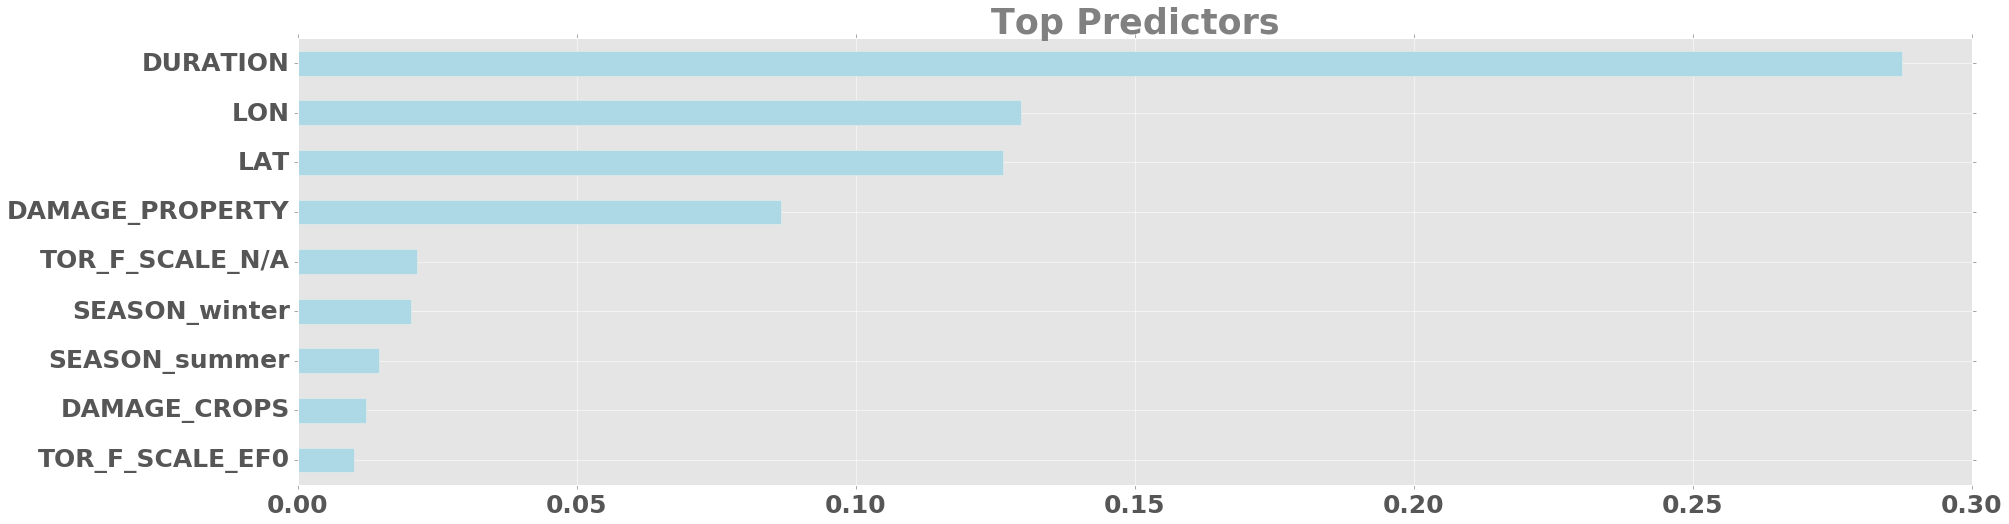

In [12]:
all_features = zip(X_valid.columns.values, rfc.feature_importances_)
all_features = sorted(all_features, key = lambda x: x[1], reverse=True)
top_features = pd.DataFrame(all_features[:9])
top_features.set_index([0], inplace = True)
top_features.sort_values(by=1, ascending=True, inplace=True)
del top_features.index.name

plt.close('all')
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
plt.rc('font', weight='bold')
plt.rcParams["figure.figsize"] = [30,8]
ax = top_features.plot(kind='barh', color ='lightblue',legend=False)
#ax.set_xlabel('Weight',fontsize=30)
#ax.set_ylabel('Predictor',fontsize=30)
ax.set_title('Top Predictors',fontsize=35, color='grey', fontweight='bold')
path = "./figs/storms_rf_predictors.png"
plt.savefig(path)